# Cloud removal inference

* **Last Modified**: 01-12-2021
* **Authors**: Gonzalo Mateo-García
---

> Run inference dual headed multioutput binary classification model

This notebook shows how to load a trained model from a experiment config file. With that model we will then make predictions on new Sentinel-2 images. In this case we will use a model that produce an output image with two channels. The first channel  encodes the probability of cloud and the second channel the probability of water. With this new model we are able to correctly classify land/water in partially cloud covered places and over thin and semi-transparent clouds.

In [1]:
# !pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

In [2]:
import sys, os
from pathlib import Path

# %load_ext autoreload
# %autoreload 2

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../data/ml4cc-general-access_request_pays.json"
os.path.exists(os.environ["GOOGLE_APPLICATION_CREDENTIALS"])

True

## Step 1: Get config

In [4]:
from ml4floods.models.config_setup import get_default_config

# experiment_name = "WF2_unet50"
# checkpoint_name = "epoch=5-step=16433.ckpt"
experiment_name = "WF2_Unet_unused_from_checkpoint"
# checkpoint_name = "epoch=5-step=24215.ckpt"

config_fp = f"/media/disk/databases/WORLDFLOODS/2_MLModelMart/{experiment_name}/config.json"
config = get_default_config(config_fp)

# The max_tile_size param controls the max size of patches that are fed to the NN. If you're in a memory contrained environment set this value to 128
config["model_params"]["max_tile_size"] = 128

Loaded Config for experiment:  WF2_Unet_unused_from_checkpoint
{   'data_params': {   'batch_size': 32,
                       'bucket_id': '',
                       'channel_configuration': 'all',
                       'download': {   'test': False,
                                       'train': False,
                                       'val': False},
                       'filter_windows': {   'apply': True,
                                             'threshold_clouds': 0.8,
                                             'version': 'v2'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': '/media/disk/databases/WORLDFLOODS/2_Mart/worldfloods_extra_v2_0',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '/home/kike/Projectes/ml4floods/splits/spli

## Step 2: Load pre-trained model

In [5]:
from ml4floods.models.worldfloods_model import ML4FloodsModel

from ml4floods.models.model_setup import get_model

config["model_params"]['model_folder'] = '/media/disk/databases/WORLDFLOODS/2_MLModelMart/'
config["model_params"]['test'] = True
model = get_model(config.model_params, experiment_name)

model.eval()
# model.to("cuda:0")

Loaded model weights: /media/disk/databases/WORLDFLOODS/2_MLModelMart/WF2_Unet_unused_from_checkpoint/model.pt


ML4FloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [6]:
from ml4floods.models.model_setup import get_model_inference_function

config["model_params"]["max_tile_size"] = 1024
inference_function = get_model_inference_function(model, config,apply_normalization=True,activation="sigmoid")

Getting model inference function
Max tile size: 1024


In [7]:
from rasterio import plot as rasterioplt
from ml4floods.data.worldfloods import configs
from typing import Union, Optional
import rasterio.windows
import numpy as np

INTERPRETATION_INVLANDWATER = ["invalid", "land", "water"]

def plots_preds_v2(prediction: Union[str, np.ndarray],transform:Optional[rasterio.Affine]=None,
                   window:Optional[rasterio.windows.Window]=None, legend=True,
                   size_read:Optional[int]=None,
                   **kwargs):
    """
    Prediction expected to be binary.
    Args:
        prediction:
        transform:
        window:
        legend:
        size_read:
        **kwargs:

    Returns:

    """
    prediction_show = prediction + 1
    cmap_preds, norm_preds, patches_preds = plot_utils.get_cmap_norm_colors(configs.COLORS_WORLDFLOODS_INVLANDWATER,
                                                                 INTERPRETATION_INVLANDWATER)

    ax = rasterioplt.show(prediction_show, transform=transform, cmap=cmap_preds, norm=norm_preds,
                          interpolation='nearest',**kwargs)

    if legend:
        ax.legend(handles=patches_preds,
                  loc='upper right')

    return ax

## Perform Inference using the `inference_function`

torch.Size([13, 5731, 5400])
torch.Size([2, 5731, 5400])
CPU times: user 2.13 s, sys: 2.92 s, total: 5.05 s
Wall time: 4.14 s


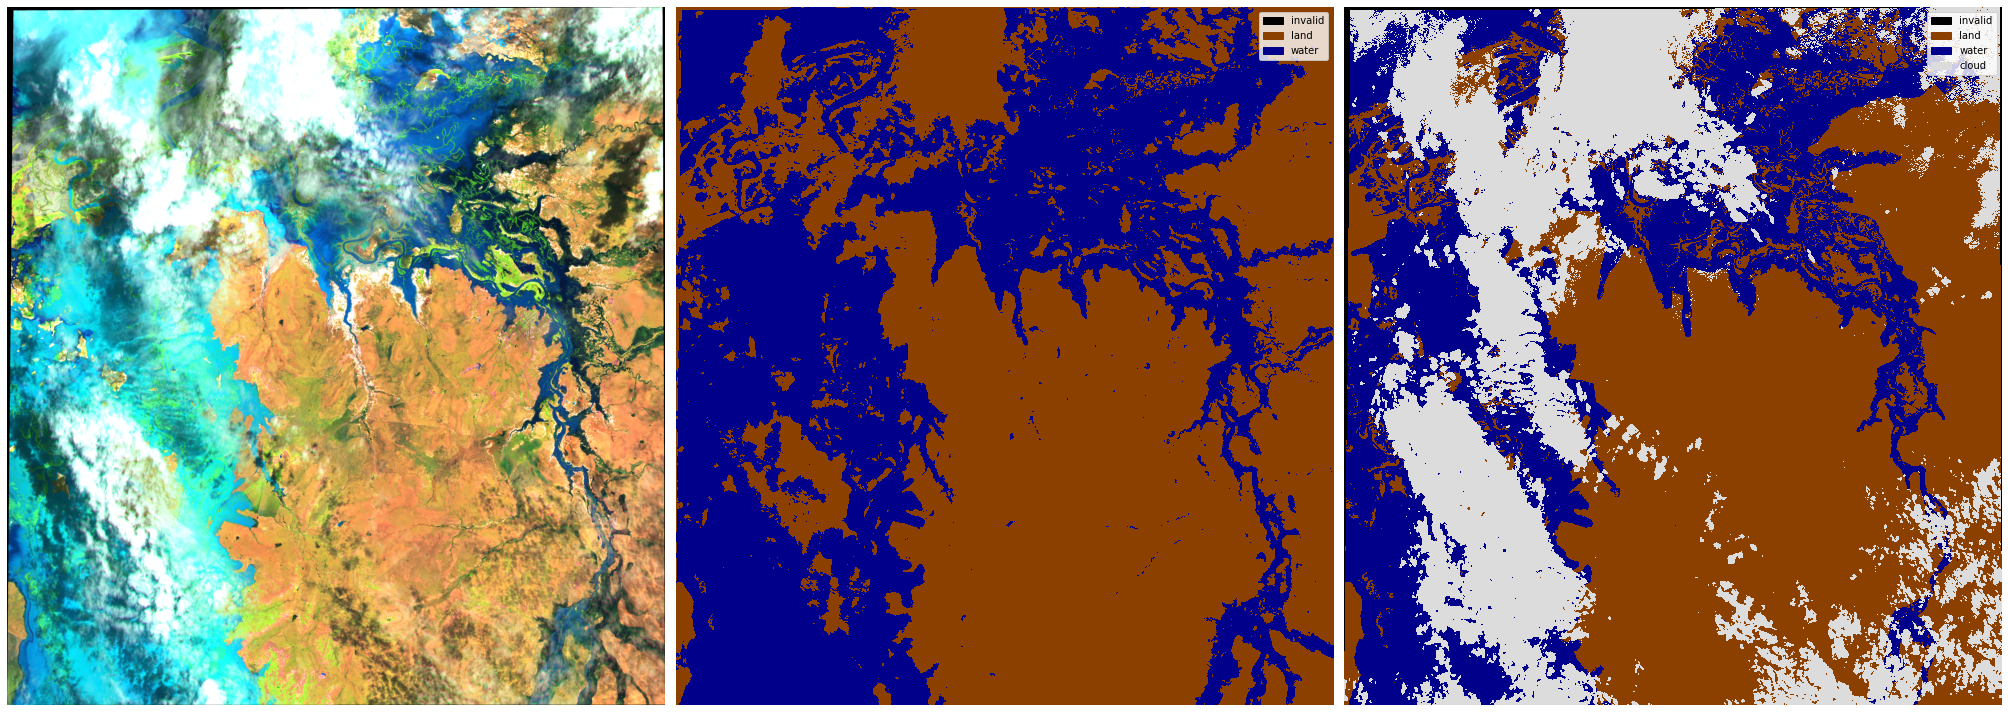

In [22]:
%%time

from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import matplotlib.pyplot as plt


tiff_s2 = "/media/disk/databases/WORLDFLOODS/2_Mart/worldfloods_extra_v2_0_NEW/test/S2/EMSR342_06NORTHNORMANTON_DEL_v1.tif"
tiff_gt = tiff_s2.replace("/S2/", "/gt/")

# window = (slice(1000,2000),slice(2000,3000))
window = None
channels = get_channel_configuration_bands(config.model_params.hyperparameters.channel_configuration)

threshold = .8
# window = None

torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
print(torch_inputs.shape)

outputs = inference_function(torch_inputs.unsqueeze(0))[0] # (num_classes, h, w)
binary_water_mask = (outputs[1]>threshold).long()
print(outputs.shape)
fig, axs = plt.subplots(1,3, figsize=((28,12)))
plot_utils.plot_s2_swirnirred_image(torch_inputs, transform=transform, ax=axs[0])
plots_preds_v2(binary_water_mask,transform=transform, ax=axs[1])
plot_utils.plot_gt_v2(tiff_gt, transform, ax=axs[2])
for ax in axs:
    ax.axis("off")
plt.tight_layout()

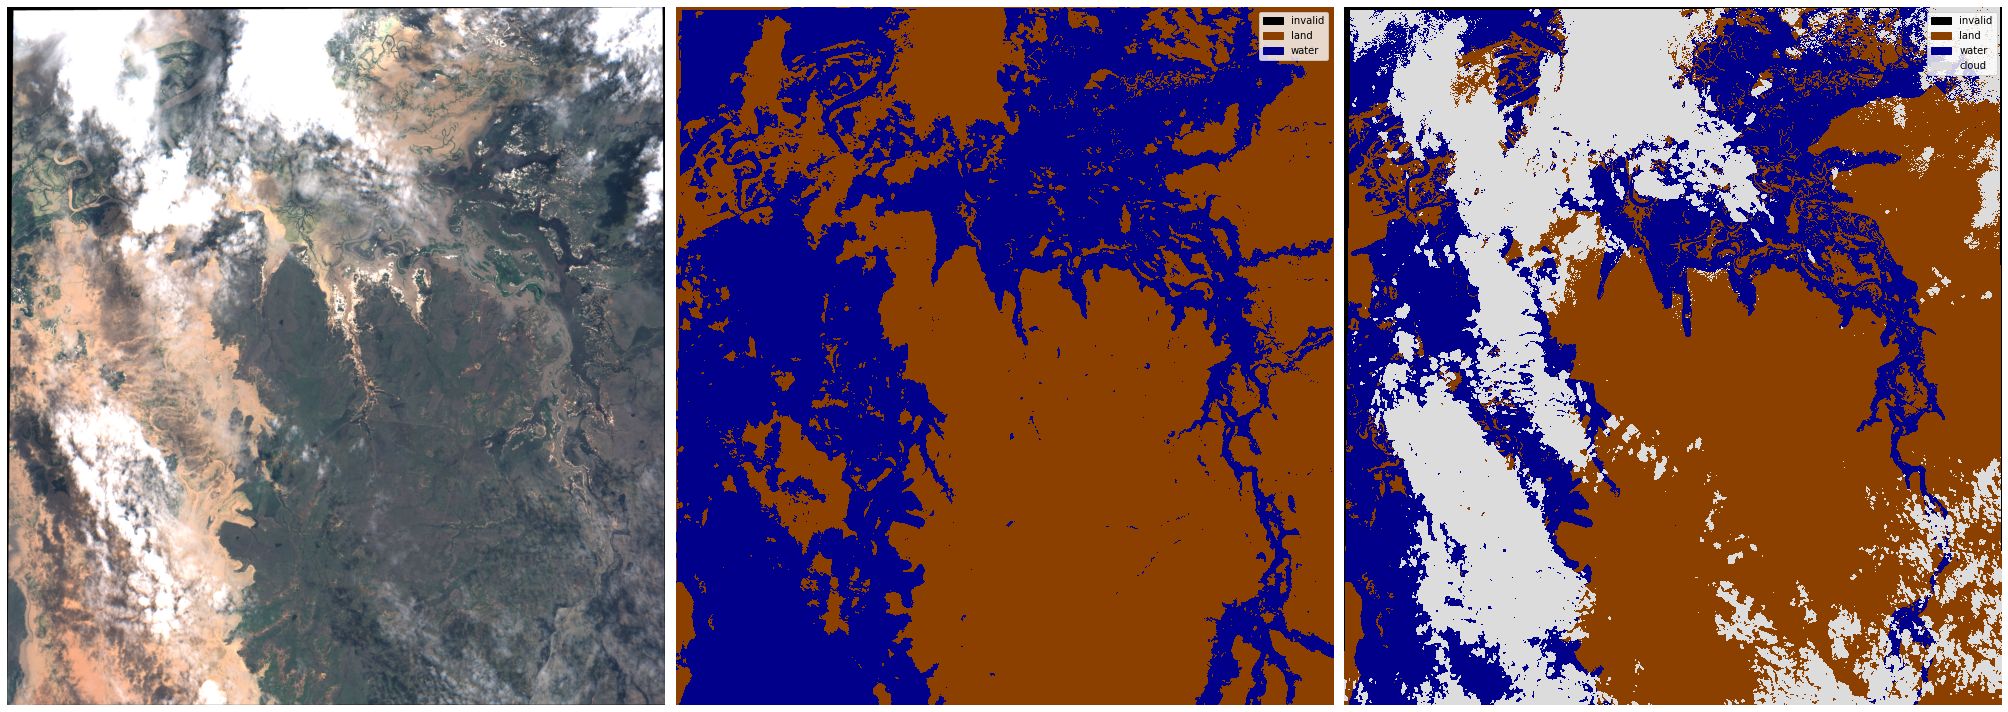

In [23]:
fig, axs = plt.subplots(1,3, figsize=((28,12)))
plot_utils.plot_s2_rbg_image(torch_inputs, transform=transform, ax=axs[0])
plots_preds_v2(binary_water_mask,transform=transform, ax=axs[1])
plot_utils.plot_gt_v2(tiff_gt, transform, ax=axs[2])
for ax in axs:
    ax.axis("off")
plt.tight_layout()